# **SENTIMENT BASED RECOMMENDATION**




In [ ]:
#general purpose libraries
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)
pd.set_option("display.precision", 2)

In [ ]:
# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#Modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

### Loading the Dataset

In [ ]:
import sklearn
print(sklearn.__version__)
print(np.__version__)
print(pd.__version__)
print(nltk.__version__)

1.2.2
1.22.4
1.5.3
3.8.1


In [ ]:
# importing dataset
df_reviews = pd.read_csv("/content/sample30.csv",error_bad_lines=False)
df_reviews.head()

ParserError: ignored

### Exploratory Data Analysis - Data Cleaning and Preprocessing

In [ ]:
df_reviews.info()

In [ ]:
def calcMissingRowCount(df):
    # summing up the missing values (column-wise) and displaying fraction of NaNs
    return df.isnull().sum()

calcMissingRowCount(df_reviews)

In [ ]:
# Remove the missing row of user_sentiment
df_reviews = df_reviews[~df_reviews.user_sentiment.isnull()]

In [ ]:
#map the categorical user_sentiment to numerical 1 or 0 for modelling
df_reviews['user_sentiment'] = df_reviews['user_sentiment'].map({'Positive':1,'Negative':0})

In [ ]:
#get the value count of user_sentiments column
df_reviews["user_sentiment"].value_counts(normalize=True)

Positive    0.89
Negative    0.11
Name: user_sentiment, dtype: float64

<Axes: xlabel='user_sentiment', ylabel='count'>

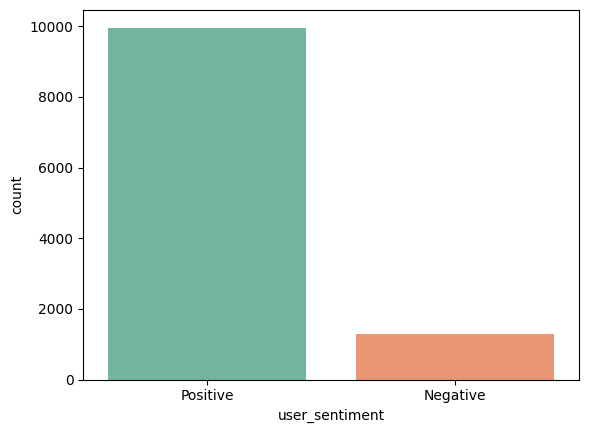

In [ ]:
#Visualize using count plot
sns.countplot(x='user_sentiment', data= df_reviews, palette="Set2")

We can see overrepresentation of positive reviews. we may have to do Class Imbalance techniques during modelling.

In [ ]:
df_reviews["reviews_rating"].describe()

In [ ]:
df_reviews["reviews_rating"].value_counts()

5    7596
4    2813
3     447
1     244
2     140
Name: reviews_rating, dtype: int64

<Axes: xlabel='reviews_rating', ylabel='count'>

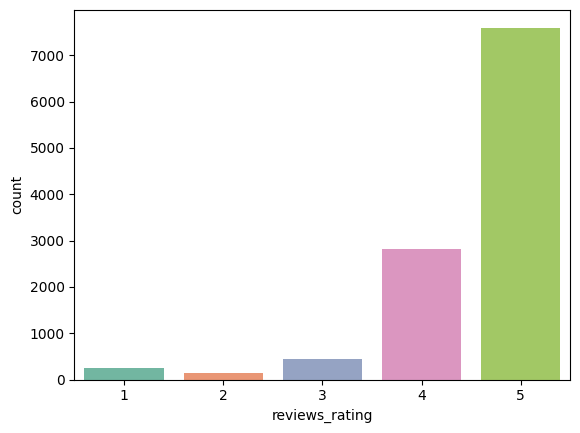

In [ ]:
#visualize the user_rating..
sns.countplot(x='reviews_rating', data= df_reviews, palette="Set2")

In [ ]:
df_reviews[df_reviews["user_sentiment"]==1]["reviews_rating"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: reviews_rating, dtype: float64

In [ ]:
df_reviews[df_reviews["user_sentiment"]==0]["reviews_rating"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: reviews_rating, dtype: float64

In [ ]:
df_reviews[(df_reviews["user_sentiment"]==1) & (df_reviews["reviews_rating"]<4)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating


In [ ]:
df_reviews[(df_reviews["user_sentiment"]==0) & (df_reviews["reviews_rating"]>=4)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating


In [ ]:
pd.crosstab(df_reviews["user_sentiment"], df_reviews["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
Negative,106,51,75,304,741,1277
Positive,138,89,372,2509,6855,9963
All,244,140,447,2813,7596,11240


As per the above results, there looks to be mismtach between review_rating and user_sentiment. there are records that have higher user rating but user sentiment is negative and lower user rating but user sentiment is positive. We can either clean up those records or update the target column to the correct user sentiment, so that will be helpful for modelling. Here, updating the user_sentiment to 0 (but was 1) when the reviews_rating is less than 4, and updating the user_sentiment to 1(but was 0), when the reviews_rating is greater than or equal to 4

In [ ]:
df_reviews.loc[(df_reviews["user_sentiment"]==1) & (df_reviews["reviews_rating"]<4), "user_sentiment"] = 0

In [ ]:
df_reviews.loc[(df_reviews["user_sentiment"]==0) & (df_reviews["reviews_rating"]>=4), "user_sentiment"] = 1

In [ ]:
pd.crosstab(df_reviews["user_sentiment"], df_reviews["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
Negative,106,51,75,304,741,1277
Positive,138,89,372,2509,6855,9963
All,244,140,447,2813,7596,11240


from the above table, we can see that we don't have mismatch between the reviews_rating and user_sentiment

In [ ]:
df_reviews["user_sentiment"].value_counts()

Positive    9963
Negative    1277
Name: user_sentiment, dtype: int64

In [ ]:
df_reviews["brand"].value_counts()

Clorox                            4761
Sony Pictures                      845
FOX                                757
Summit Entertainment               672
Universal Home Video               668
                                  ... 
Citrus Magic                         1
Jake And The Neverland Pirates       1
La Tortilla Factory                  1
Hortense B. Hewitt                   1
Universal Music                      1
Name: brand, Length: 84, dtype: int64

IndexError: ignored

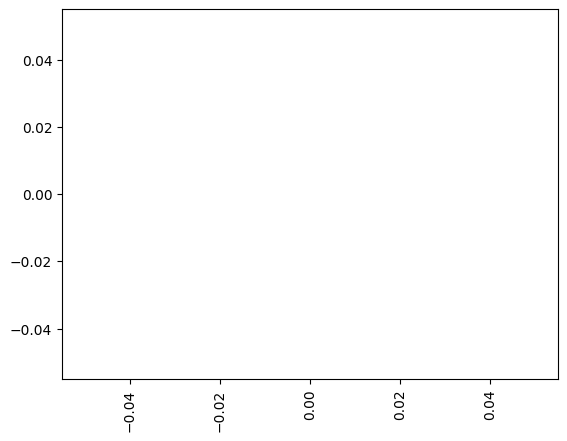

In [ ]:
# Filter the top 10 brands among the positive sentiments
df_reviews[df_reviews['user_sentiment']==1].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar',color='g')

<Axes: xlabel='brand'>

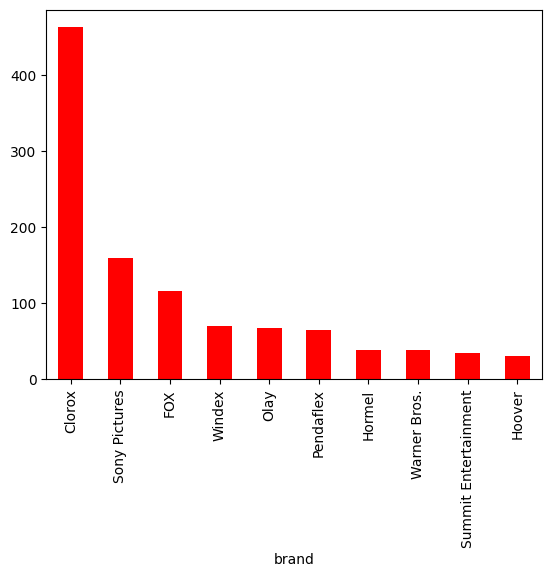

In [ ]:
# Filter the top 10 brands among the negative sentiments
df_reviews[df_reviews['user_sentiment']==0].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar', color='r')

In [ ]:
def filter_products(productId, pos=1):
    review_count = df_reviews[(df_reviews.id==productId) & (df_reviews.user_sentiment==pos)]['brand'].count()
    return review_count

In [ ]:
#group the dataframe by product id and view the # of pos review / neg reviews count
df_custom =  df_reviews.groupby('id', as_index=False)['user_sentiment'].count()
df_custom["pos_review_count"] =  df_custom.id.apply(lambda id: filter_products(id, 1))
df_custom["neg_review_count"] =  df_custom.id.apply(lambda id: filter_products(id, 0))

In [ ]:
df_custom.head(10)

,id,user_sentiment,pos_review_count,neg_review_count
0,AV13O1A8GV-KLJ3akUyj,1,1,0
1,AV14LG0R-jtxr-f38QfS,2,2,0
2,AV16khLE-jtxr-f38VFn,27,14,13
3,AV1YGDqsGV-KLJ3adc-O,348,278,70
4,AV1YIch7GV-KLJ3addeG,1,0,1
5,AV1YlENIglJLPUi8IHsX,17,15,2
6,AV1YmBrdGV-KLJ3adewb,18,16,2
7,AV1YmDL9vKc47QAVgr7_,89,82,7
8,AV1Ymf_rglJLPUi8II2v,34,31,3
9,AV1Yn94nvKc47QAVgtst,25,20,5


In [ ]:
#sort the product by sentiment % - postive reviews / total number of reviews
df_custom['sentiment %'] = np.round((df_custom['pos_review_count']/df_custom['user_sentiment'])*100,2)
df_custom.sort_values(by='sentiment %', ascending=False)[:20]

,id,user_sentiment,pos_review_count,neg_review_count,sentiment %
0,AV13O1A8GV-KLJ3akUyj,1,1,0,100.0
49,AVpe5tC61cnluZ0-ZZ86,1,1,0,100.0
21,AV1d76w7vKc47QAVhCqn,6,6,0,100.0
23,AV1h6gSl-jtxr-f31p40,4,4,0,100.0
50,AVpe5ttZLJeJML43x4yO,4,4,0,100.0
25,AV2AvGnjGV-KLJ3alTQH,1,1,0,100.0
26,AV2Avn5dGV-KLJ3alTjq,1,1,0,100.0
27,AV2BOOWS-jtxr-f39GPS,1,1,0,100.0
30,AVpe-PJnLJeJML43ziaj,9,9,0,100.0
18,AV1ZSp2uglJLPUi8IQFy,7,7,0,100.0


In [ ]:
#Let's find out the most common users.
df_reviews["reviews_username"].value_counts()[:10]

In [ ]:
#plot the customers by 'positive user sentiment'
df_reviews[df_reviews['user_sentiment']==1].groupby('reviews_username')['reviews_username'].count().sort_values(ascending=False)[:10].plot(kind='bar', color='g')

In [ ]:
#plot the customers by 'negative user sentiment'
df_reviews[df_reviews['user_sentiment']==0].groupby('reviews_username')['reviews_username'].count().sort_values(ascending=False)[:10].plot(kind='bar', color='r')

In [ ]:
#removing nan/null from username
df_reviews = df_reviews[~df_reviews.reviews_username.isnull()]

In [ ]:
#Let's combine the reviews_text and reviews_title for better analysis
df_reviews["reviews_title"] = df_reviews["reviews_title"].fillna('')
df_reviews["reviews_full_text"] = df_reviews[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')

In [ ]:
#get the missing row cout for each of the columns
calcMissingRowCount(df_reviews)

Required columns for reviews_rating, reviews_text, user_sentiment,reviews_username doesn't have null/na values

### Text Preprocessing for Modelling

In [ ]:
import string

In [ ]:
df_reviews[["reviews_full_text", "user_sentiment"]].sample(10)

In [ ]:
'''function to clean the text and remove all the unnecessary elements.'''
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub("\[\s*\w*\s*\]", "", text)
    dictionary = "abc".maketrans('', '', string.punctuation)
    text = text.translate(dictionary)
    text = re.sub("\S*\d\S*", "", text)

    return text

In [ ]:
df_clean = df_reviews[['id','name', 'reviews_full_text', 'user_sentiment']]

In [ ]:
df_clean["reviews_text"] = df_clean.reviews_full_text.apply(lambda x: clean_text(x))

In [ ]:
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
stop_words = set(stopwords.words('english'))

def remove_stopword(text):
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)

In [ ]:
lemmatizer = WordNetLemmatizer()
# Lemmatize the sentence
def lemma_text(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopword(text))) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(words)

In [ ]:
df_clean["reviews_text_cleaned"] = df_clean.reviews_text.apply(lambda x: lemma_text(x))

In [ ]:
df_clean.head()

reviews_text is cleaned to remove stopwords, punctuations,numericals,whitespaces and lemma is derived.

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stop_words,max_words=200).generate(str(df_clean.reviews_text_cleaned))

print(wordcloud)
plt.figure(figsize= (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [ ]:
def getMostCommonWords(reviews, n_most_common):
    # flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]


    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]


    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)

In [ ]:
pos_reviews = df_clean[df_clean['user_sentiment']==1]
getMostCommonWords(pos_reviews['reviews_text_cleaned'],10)

In [ ]:
neg_reviews = df_clean[df_clean['user_sentiment']==0]
getMostCommonWords(neg_reviews['reviews_text_cleaned'],10)

In [ ]:
#function to collect the n-gram frequency of words
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(pos_reviews['reviews_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

In [ ]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(neg_reviews['reviews_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

In [ ]:
#logic to find the top 10 trigram frequency among the reviews_text in the cleaned datafram(df_clean).
common_words = get_top_n_ngram(df_clean.reviews_text_cleaned, 3, 10)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[35,25])
fig = sns.barplot(x=df3['trigram'], y=df3['count'])

In [ ]:
X = df_clean['reviews_text_cleaned']
y = df_clean['user_sentiment']

### Feature Extraction

In [ ]:
no_of_classes= len(pd.Series(y).value_counts())

In [ ]:
#Distribution of the target variable data in terms of proportions.
for i in range(0,no_of_classes):
    print("Percent of {0}s: ".format(i), round(100*pd.Series(y).value_counts()[i]/pd.Series(y).value_counts().sum(),2), "%")

To Vectorize the data, using TF-IDF vectorizer method to dervie the features from the textual data

As it's clearly a class-imbalance between positive and negative, let's do SMOTE oversampling technique before modelling

In [ ]:
#using TF-IDF vectorizer using the parameters to get 650 features.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True,
                                   ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_clean['reviews_text_cleaned'])

y= df_clean['user_sentiment']

In [ ]:
print(tfidf_vectorizer.get_feature_names_out())

In [ ]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=42, test_size=0.25)

In [ ]:
### Class imbalance (using SMOTE)

In [ ]:
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

### Model Building

In [ ]:
import time
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
import pickle

In [ ]:
class ModelBuilder:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test


    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)

    def evaluate_model(self, y_pred_class):
        print("\n")
        print("*"*30)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("*"*30)
        print("\n")

        self.classification_report(y_pred_class)
        print("*"*30)
        print("\n")
        self.confusion_matrix(y_pred_class)

        print("*"*30)
        print("\n")

        #metrics.plot_roc_curve(self.model, self.x_test, self.y_test)

        return self.result_metrics

    def evaluate_metrics(self, y_pred_class):
        result_metrics = []
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)

        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")

        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics

    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])


    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", fmt=".2%")

        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()

    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))


f1-score/recall score for class 0 is low and this could be due to class-imbalance, though the other metrics seem to be good. Let's use class-imbalance techniques using SMOTE and do the modelling

### Logistic Regression

In [ ]:
# Build the Logistic Regression model.
%time
logreg_ci = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")
lr_ci_modebuilder = ModelBuilder(logreg_ci, X_train, X_test, y_train, y_test)

In [ ]:
# Train and Predict the Test Labels
y_pred_class  = lr_ci_modebuilder.train_model()
y_pred_class
lr_metrics = lr_ci_modebuilder.evaluate_model(y_pred_class)

F1 Score looks to be good, though the individual class(0) is lesser. let;s try with other alogithms if we can increase the overall F1 and for the individual classes

### Naive Bayes

In [ ]:
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mnb = MultinomialNB(alpha=1.0)
mnb_modebuilder = ModelBuilder(mnb, X_train, X_test, y_train, y_test)

In [ ]:
# Train and Predict the Test Labels
y_pred_class  = mnb_modebuilder.train_model()
nb_metrics = mnb_modebuilder.evaluate_model(y_pred_class)

### Decision Tree

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(random_state=42, criterion="gini", max_depth=10)

In [ ]:
dt_modelbuilder = ModelBuilder(dt, X_train, X_test, y_train, y_test)

In [ ]:
y_pred_class  = dt_modelbuilder.train_model()
dt_metrics_cv = dt_modelbuilder.evaluate_model(y_pred_class)

### Random Forrest

In [ ]:
rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")

In [ ]:
params = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [10, 25, 50, 100]
}

In [ ]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1")

In [ ]:
%time
grid_search.fit(X_train, y_train)

In [ ]:
rf_best = grid_search.best_estimator_
rf_modebuilder = ModelBuilder(rf_best, X_train, X_test, y_train, y_test)

In [ ]:
# Train and Predict the Test Labels
y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

### XGBoost Classifier

In [ ]:
import xgboost as xgb

In [ ]:
xgclf = xgb.XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42) #based on the tuned parameters
xg_modebuilder = ModelBuilder(xgclf, X_train, X_test, y_train, y_test)

In [ ]:
# Train and Predict the Test Labels
y_pred_class  = xg_modebuilder.train_model()
xg_metrics = xg_modebuilder.evaluate_model(y_pred_class)

### Model Inference

In [ ]:
xg_metrics

In [ ]:
# Creating a table which contain all the metrics

metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score','Auc Score'],
        'Logistic Regression': lr_metrics,
        'Naive Bayes': nb_metrics,
        'Decision Tree': dt_metrics_cv,
         'Random Forrest': rf_metrics,
        'XG Boost': xg_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Decision Tree','Random Forrest',
                                                    'XG Boost'] )

df_metrics


Comparing the above models on the metrics, XG Boost looks to be a better model, saving the XG Boost model as a pickle file for later use

#### Saving the model

In [ ]:
def save_object(obj, filename):
    filename = "pickle\\"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [ ]:
save_object(xgclf, 'sentiment-classification-xg-boost-model')

In [ ]:
save_object(tfidf_vectorizer, 'tfidf-vectorizer')

In [ ]:
save_object(df_clean, 'cleaned-data')

## Recommendation System

Different Approaches to develop Recommendation System -

Here we are going to try with 2 of the Colloboarative filtering techniques:
    - User-User Based Approach
    - Item-Item Based Approach

In [ ]:
df_reviews.info()

In [ ]:
df_recommendation = df_reviews[["id", "name", "reviews_rating", "reviews_username"]]
calcMissingRowCount(df_recommendation)

In [ ]:
#splitting the train and test
train, test = train_test_split(df_recommendation, test_size=0.25, random_state=42)

In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
df_pivot = pd.pivot_table(train,index=user_column, columns = product_column, values = value_column).fillna(0)
df_pivot.head(10)

### Creating dummy train and test

In [ ]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [ ]:
dummy_train.head()

In [ ]:
# The products not rated by user is marked as 1 for prediction.
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)

In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
dummy_train.head(10)

### User similarity matrix

In [ ]:
df_pivot.index.nunique()

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

In [ ]:
#using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

### Prediction User-User

In [ ]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

In [ ]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

In [ ]:
#since we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

### Find 20 recommendation for the user

In [ ]:
user_input = "08dallas"
print(user_input)

In [ ]:
#display the top 20 product id, name and similarity_score
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

### Evaluation User-User

In [ ]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

In [ ]:
common.head()

In [ ]:
# convert into the user-movie matrix.
common_user_based_matrix = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()

In [ ]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

In [ ]:
user_correlation_df[user_column] = df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

In [ ]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [ ]:
user_correlation_df_1.shape

In [ ]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [ ]:
user_correlation_df_3 = user_correlation_df_2.T

In [ ]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

In [ ]:
dummy_test = common.copy()

dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)

In [ ]:
dummy_test.shape

In [ ]:
common_user_based_matrix.head()

In [ ]:
dummy_test.head()

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [ ]:
common_user_predicted_ratings.head()

In [ ]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [ ]:
common_ = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

### Item Based Recommendation

In [ ]:
df_pivot = pd.pivot_table(train,
    index=product_column,
    columns=user_column,
    values=value_column
)

df_pivot.head()

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [ ]:
df_subtracted.head()

In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

### Prediction - item-item

In [ ]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

#### Filtering the rating only for the products not rated by the user for recommendation

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

#### Finding the top 20 recommendation for the user

In [ ]:
# Take the user ID as input
user_input = '08dallas'
print(user_input)

In [ ]:
# Recommending the Top 5 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

In [ ]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

#### Evaluation - item-item

In [ ]:
common =  test[test.id.isin(train.id)]
common.shape

In [ ]:
common.head(4)

In [ ]:
common_item_based_matrix = common.pivot_table(index=product_column, columns=user_column, values=value_column)

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

In [ ]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column,inplace=True)
item_correlation_df.head()

In [ ]:
list_name = common.id.tolist()

In [ ]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [ ]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [ ]:
df_subtracted

In [ ]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

In [ ]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index=product_column, columns=user_column, values=value_column).fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [ ]:
common_ = pd.pivot_table(common,index=product_column, columns=user_column, values=value_column)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [ ]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

On comparing the RMSE values of User Based Recommender and Item Based Recommender, User based recommendation model seems to be better in this case, as it has a lower RMSE value (~2)

In [ ]:
# saving the correlation matrix of user based recommender
save_object(user_final_rating, "user_final_rating")

### Top Product Recommendations - Recommendation of 20 products and filtering by sentiment model

Get the top 20 product recommendations using the recommender system and get the top 5 using the sentiment ML model.. the similar method would be used in model.py

In [ ]:
def get_sentiment_recommendations(user):
    if (user in user_final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = df_clean[df_clean.id.isin(recommendations)]
        #temp["reviews_text_cleaned"] = temp["reviews_text"].apply(lambda x: self.preprocess_text(x))
        #transfor the input data using saved tf-idf vectorizer
        X =  tfidf_vectorizer.transform(temp["reviews_text_cleaned"].values.astype(str))
        temp["predicted_sentiment"]= xgclf.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [ ]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations("08dallas")

In [ ]:
#get the top 5
get_sentiment_recommendations("08dallas")[:5]

In [ ]:
#testing the above fuction on the user that doesn't exists or a new user
get_sentiment_recommendations("test123")

In [ ]:
X_sample = tfidf_vectorizer.transform(["Awesome product, will recommend"])
y_pred_sample = xgclf.predict(X_sample)
y_pred_sample

In [ ]:
X_sample = tfidf_vectorizer.transform(["worst product, quality is poor"])
y_pred_sample = xgclf.predict(X_sample)
y_pred_sample